In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pendulum
import tqdm

# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how value iteration and Q-learning work, their limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.


In [2]:
# we can create a robot
robot = pendulum.Pendulum()

# assume we set theta and dtheta = 0 and u = -5, we can get the next state using
x = np.array([0,0])
u = -5
x_next = robot.next_state(x, u)

## Part 2 - Tabular Q-learning
Now we want to implement the Q-learning algorithm (with a table and discretized states / actions). The difference with value iteration is that we will not assume that we can access the next state given any (x,u). We will need to run a realistic episode where we always start the pendulum at the position $[0,0]$.
1. Write a function ```q_learning(robot)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should return the Q-table as a 50x50x3 numpy array (assume that only three controls are possible as in Part 1).

2. How can you compute the optimal policy from the Q function? And the optimal value function? Write a function that does this using as an input the Q-table computed by ```q_learning(robot)```.

3. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-5,0,5\}$? (use a learning rate of 0.1)

4. How does the estimates of the value function and policy compare to the ones computed with the Value Iteration algorithm? (plot these functions) Do you see any qualitative differences in terms of the computed policy compared to the optimal solution computed with value iteration? (e.g. do they achieve the same cost? did Q-learning find the optimal value function?  why?)

5. How is learning affected when changing $\epsilon$ and the learning rate?

6. Can you learn how to invert the pendulum with the sparse cost function define in Part 1.4? Is it easier or harder? Why?

In [43]:
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

discretized_thetadot = np.linspace(-6, 6, 50)
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = (theta-np.pi)**2+0.01*theta_dot**2+0.0001*u**2
    return res

In [47]:
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = (theta-np.pi)**2+0.01*theta_dot**2+0.0001*u**2
    return res

class Q_solver:
    def __init__(self,robot, costfn = cost, actions=None, max_iters=5000, sparse_loss=False):
        self.robot: pendulum = robot
        if actions is None:
            actions = [-5, 0, 5]
        self.action_list = np.array(actions)
        self.lr = 0.1
        self.epslion = 0.1
        self.step_in_iter = 100
        self.alpha = 0.99
        self.max_iters = max_iters
        self.sparse_loss = sparse_loss
        self.costfn = costfn
        self.discretized_theta = discretized_theta
        self.discretized_theta_dot = discretized_thetadot
        self.space_shape = [len(discretized_theta),len(discretized_thetadot)]

        self.num_states = 50*50
        self.nu = 3
        self.nq = 50
        self.make_state_transfer_table()
    def make_state_transfer_table(self):
        next_state_index = np.empty([self.num_states, self.nu], dtype=np.int32)
        for i in range(self.num_states):
            for k in range(self.nu):
                x_next = robot.next_state(self.get_states(i), self.action_list[k])
                next_state_index[i, k] = self.get_index(x_next)

        self.state_transfer_table = next_state_index #[250 3 2]


    def get_index(self,x):
        ind_q = np.argmin((x[0] - self.discretized_theta) ** 2)
        ind_v = np.argmin((x[1] - self.discretized_theta_dot) ** 2)
        return ind_q + ind_v * self.nq

    def get_states(self, index):
        iv, ix = np.divmod(index, self.nq)
        return np.array([self.discretized_theta[ix], self.discretized_theta_dot[iv]])


    def iterate(self):
        q = np.zeros([self.num_states, self.nu])
        q_Last = np.zeros([self.num_states, self.nu])
        for i in tqdm.tqdm(range(self.max_iters)):  #

            # choose initial state x0
            x_0 = np.array([0, 0])
            x_index = self.get_index(x_0)
            for j in range(self.step_in_iter):

                if np.random.uniform(0, 1) > self.epslion:
                    u_index = np.argmin(q[x_index, :])
                else:
                    u_index = np.random.randint(0, self.nu - 1)
                # observe x_t+1
                next_index = self.state_transfer_table[x_index, u_index]
                # compute g(x_t,u(x_t))
                x = self.get_states(x_index)
                u = self.action_list[u_index]
                # compute TDerror
                TDerror = self.costfn(x, u) + self.alpha * min(q[next_index, :]) - q[
                    x_index, u_index]
                q[x_index, u_index] = q[x_index, u_index] + self.lr * TDerror
                x_index = next_index

            # we update the current Q function if there is any change otherwise we are done
            if ((q_Last - q) ** 2 < 1e-5).all():
                break
            else:
                q_Last = q.copy()

        policy = np.zeros(self.space_shape)
        value_function = np.zeros(self.space_shape)
        for k in range(self.num_states):
            iv, ix = np.divmod(k, self.nq)
            policy[ix,iv] = self.action_list[np.argmin(q[k, :])]
            value_function[ix,iv] = min(q[k, :])
        return value_function,policy
solver = Q_solver(robot,cost,max_iters=50000)
value,policy = solver.iterate()



 14%|█▍        | 7241/50000 [00:15<01:30, 471.66it/s]


In [50]:
policy

array([[ 0., -5., -5., ...,  5.,  5.,  5.],
       [-5., -5., -5., ...,  5.,  5.,  5.],
       [ 0.,  0., -5., ...,  0.,  5.,  5.],
       ...,
       [-5., -5.,  0., ...,  5.,  5.,  0.],
       [-5., -5., -5., ...,  5.,  0.,  5.],
       [-5., -5., -5., ...,  5.,  5.,  5.]])

<IPython.core.display.Javascript object>


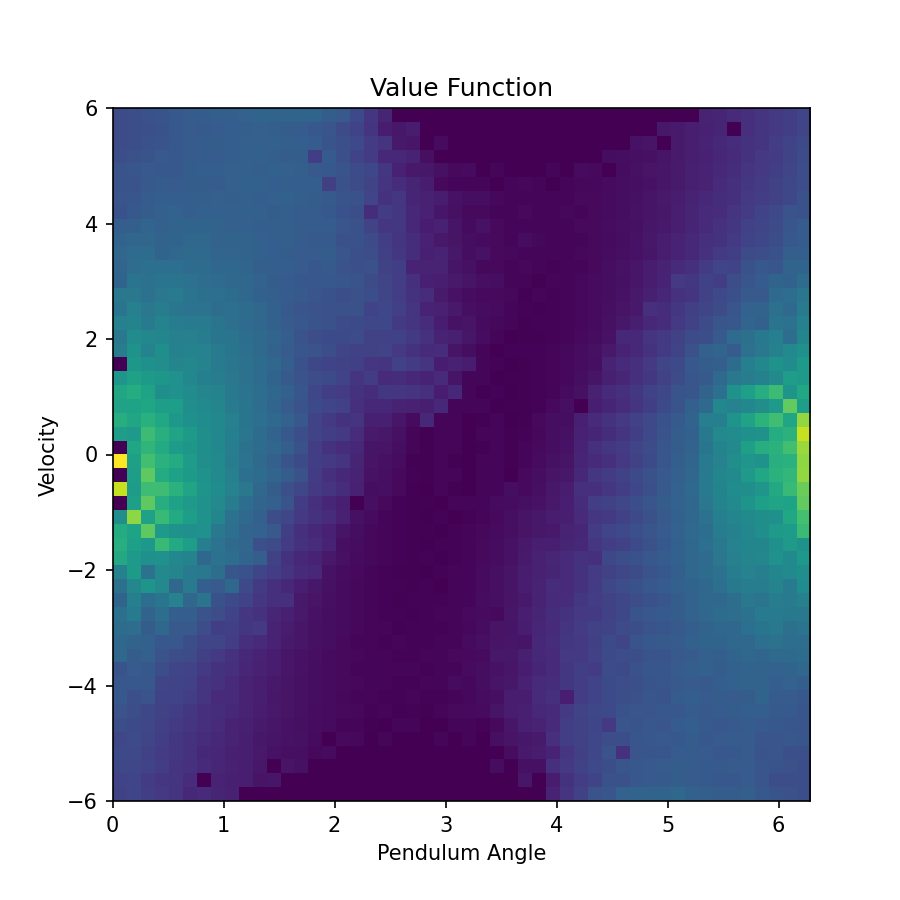

<IPython.core.display.Javascript object>


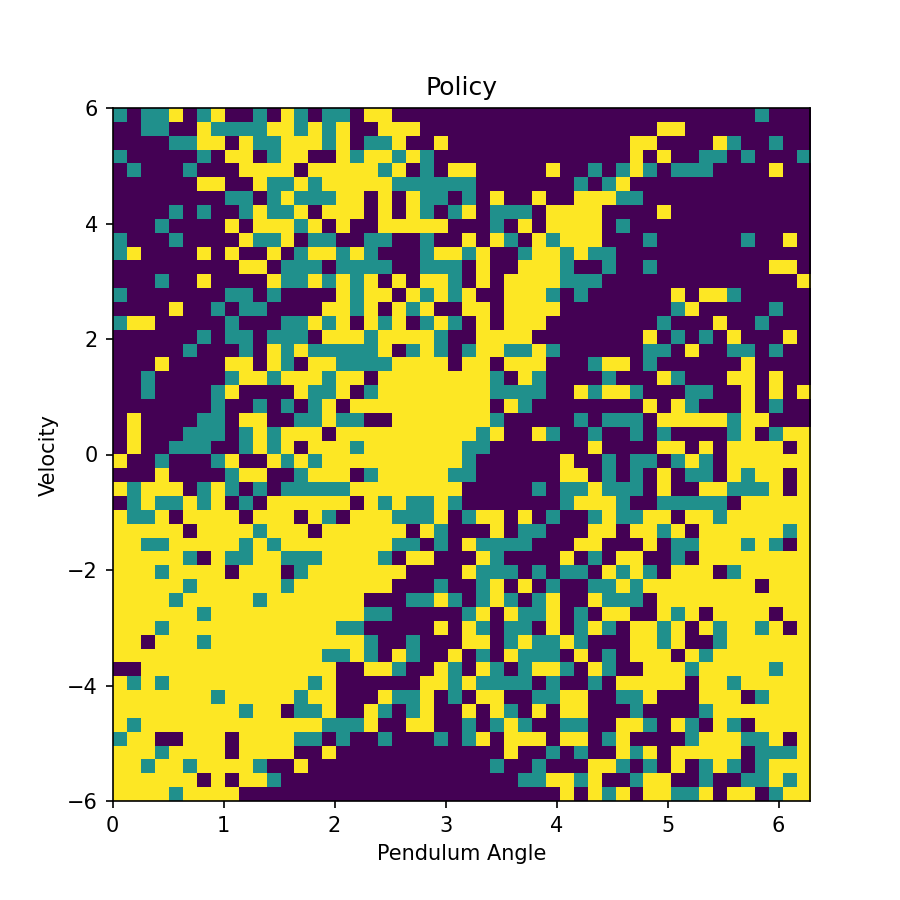

In [51]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2
# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

# now we simulate the dynamics for 100 time steps
x0 = np.array([0.,0.])

def controller(x):
    theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
    dtheta = np.linspace(-6, 6, 50)
    
    th_index = np.argmin(np.abs(theta - x[0]))
    dth_index = np.argmin(np.abs(dtheta - x[1]))
    return policy[th_index, dth_index]



<IPython.core.display.Javascript object>


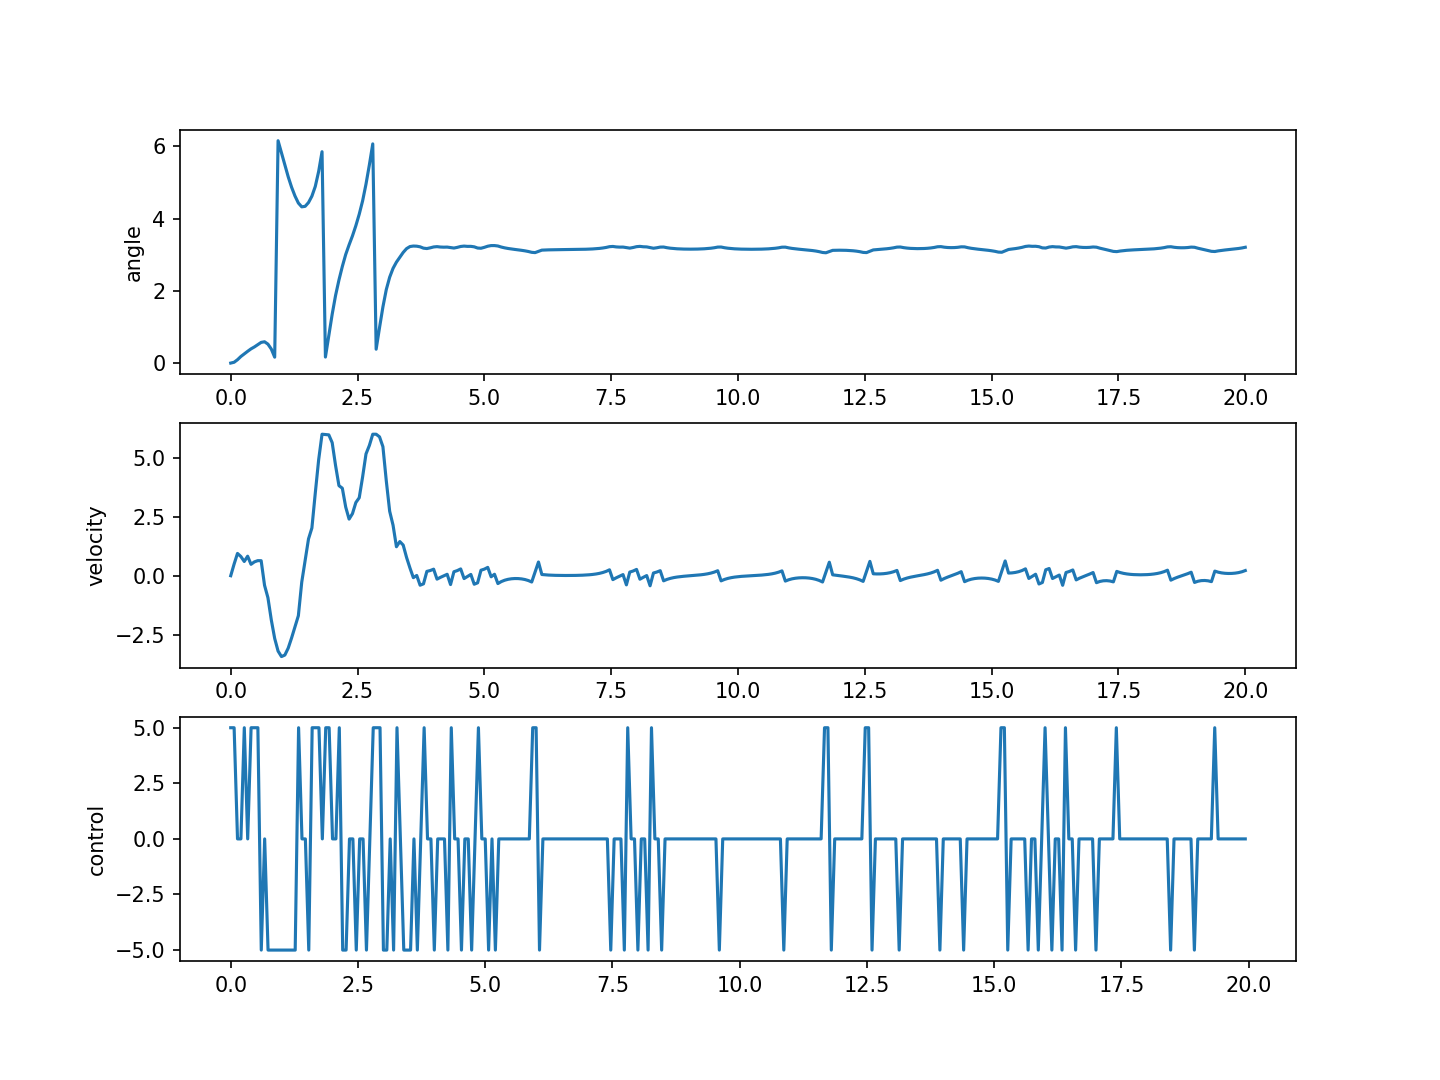

Text(0, 0.5, 'control')

In [52]:
x, u = robot.simulate(x0, controller, 30)

# and plot the results
time = np.linspace(0.,20., len(x[0,:]))
plt.figure()
plt.subplot(3,1,1)
plt.plot(time,x[0,:])
plt.ylabel('angle')
plt.subplot(3,1,2)
plt.plot(time,x[1,:])
plt.ylabel('velocity')
plt.subplot(3,1,3)
plt.plot(time[:-1],u)
plt.ylabel('control')



In [53]:
# and show an animation
robot.animate_robot(x, robot.delta_t)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABL/RtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRNliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI90bCsIyVc4u3PdLfonjvTAsNJVxmETQokGg2YmVSOf
r9cf7n4gzRN5w/yGp0C8urfaPNw7GLtuDKgU7CvsIolbNMN0bp4uNQArcYt3tWUUqb0q6OjBYObX
juYjxUGZABKLLHFN/6veiTXwCvzZQezV/g5HRLV1YnFqdeWGDbkCWfZmb1bEe4o0ZC8xjpEr120J
my/+CpVN/LCBb43mUw7YT7/K5nbUFjE2fWbHzRkNPuFoiIUAihHtmqc5GMh8KZmydt11qyMhkGLn
FFXrtho2ClWJWeetPg1hhapwI4HkY4/lqd7PdT98WYnH/7fy4MVhY8XXUGTwUhNXsk8tjiPqeltX
ADyJRFFavntZkvu+zaX28uMbT6WM/MgzebP/5IgawXlFJWPgLbOX+bgXnmLrhUWxSjN3LOg4AVp4
GpLl2iUNdOEv24+I0WdswW69aIpab8sMQYo9BbKBotiaDRx+0fC427CuVpPCqyTnUBKn+gAX/8xj
yDIXb44+UHklBUWL3yDAQcoTDpE3sefTRQ4U9sUJGj2kFGltXifbADJsIu7CSHyhtgvd+57WFbDZ
rGkINclUJgrid2M2br78Wa6I16nezLC5Y4+Mg5XplCcOVZNENDUSvU5Fjc2umXdketI4v3JtltNI
lMLf8ZvD2Ct4L4VkDbV8ldY3b2loU5XObNAR21z6j6aCsOaps3mK/4YgXoG2DMw3uyw6wLCPZmPf
KwboUeJieqBEBK9qKQPf35B8ZPQ2T6Mo3BRP7GBznjoq2F378Her2cnSJt6IbTJrN9GL3IJQypSq
ydkzuqqIv4K2CH9wN6QU4nQ/WsJVM1yfM7V+Hhswu574quf5U7zLUpSxxQTIWAAH+jOC4+H8jv2n
BsBoq3DkKu35ndUsjibUEyWdqKPRsLsldafPZn38m6eLf/ArZMOJfPALjRa6ZiibfyDFColwmCwa
APGCc4XRHlhLykxU+gLY/dc4L3AZk/LkwZQEu91lbRq1qosiOLx2PRk2MbsaiAueY8hXvEXO79Sk
E9ssoprZTlKQZabUq0ubd7QC2W1sHfybB4AHZvyhuhMUm7CvgpHWPDWHCaOPfvuEGwUZYKEbKLuV
+9iZKgfT7e/qu7k1fWSh8H1dJbSRYosguDj9xUD450HantIoizn/+Ke62zeSlWWjuAAdfg1tFwlQ
nyIHlcp8Gge+zbDPrfH8Hr2o9zSkCoIzjs/h7iFK7FhQesTt2UGw28K/nGQ4R9FPPr1FBPvbzHBF
QTmi3hXZRG3vLnsumno3PMEnKlosUXKhnTpRAN+F8nDZ9mitixp2Vgag4kOpciuU1kvDv7Z7EnQV
fTd7FOg+m68Fd1+S5BtFozAhT1UTp1uhZkze5EmX5O290UGu5YGJ7ybELtaM7rtLC6bf92re1Fzk
/ZdlXYx7Wh6vSEwgFzWoasGpZhDA9OPGCN4NJA7VKn/MeQD5mhUHtQ+iBGLRj2ATIYLWGNPSJua7
4rlezAPgdbygReNgTlLguKtuMJ7Pw//nKh7WjSNlw5n3gA1tXlymtEgSMDD8/DtpM68NIT0WIBdX
yG26mVg0lGEWj2QH/6YQkJlTzfx+BnRzFlaQHGgn+v6Sj1+IV9UogG4UfYRJlulRnKb7cOGUCHaj
cz7dJswdoer0DdZ49KcDoKgEZenukVDpvFYeW5wrJXxCKOg/+TO+FtkkAAAH4PtEXwjwMR2S7f/T
SiLAB+Hn/cPCwgANf4A1XVOiGw9kn7KmOoS3s+UAKlZiOsVfRgNAl4Z4L6VKHlp1brPpw7pVz/P1
6tqoXDdWfFTxwIIvzVqPtc+MxOrtHZfSforBerY3lLX8c73h/b/OkO/2SOqfc36LebEGnWtWZ/4x
fACDmWSgeYRRpHkUsY9g5PtsFMdffcUmQfzEnnYIK8KvQap0IiY0gtdzl28CcS2SOex/TOYyqjVb
HzeKvp2pzC5BTFaAe3YCeJ3hTSDwXcE6VqNXdZDBNI+cK6b2dJxbn6mhgDJUgU25cphhozIIxhkC
KnjkjfH8Whk8p/esK+7JKcOLPEiFGm/V0gFcPF8OgqmS+nbHjcBP5Sf3oegi6TGWj4c1YpGYjEom
FtApPy54iQPxAqQC9M9AVzNBxsFxl68NSbo/5DM12WD7zOZGSkjZs1CUg0WS36DnFwIfFOGtw+45
lTDh3GJwo8HslY76enZQk

### 2.6
sparse loss

In [54]:
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

discretized_thetadot = np.linspace(-6, 6, 50)


In [66]:
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = (theta-np.pi)**2+0.01*theta_dot**2+0.0001*u**2
    return res

In [78]:
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = 0 if abs(theta-np.pi)<0.2  else 1
#     res = (theta-np.pi)**2
    return res

In [79]:
class DQ_solver:
    def __init__(self, robot, costfn=cost, actions=None, max_iters=400, sparse_loss=False):
        self.robot: pendulum = robot
        if actions is None:
            actions = [-5, 0, 5]
        self.action_list = np.array(actions)
        self.lr = 0.1
        self.epslion = 0.1
        self.step_in_iter = 100
        self.gamma = 0.9
        self.max_iters = max_iters
        self.sparse_loss = sparse_loss
        self.costfn = costfn
        self.discretized_theta = discretized_theta
        self.discretized_theta_dot = discretized_thetadot
        self.space_shape = [len(discretized_theta), len(discretized_thetadot)]

        self.num_states = 50 * 50
        self.nu = 3
        self.nq = 50
        self.make_state_transfer_table()

    def make_state_transfer_table(self):
        next_state_index = np.empty([self.num_states, self.nu], dtype=np.int32)
        for i in range(self.num_states):
            for k in range(self.nu):
                x_next = robot.next_state(self.get_states(i), self.action_list[k])
                next_state_index[i, k] = self.get_index(x_next)

        self.state_transfer_table = next_state_index  # [250 3 2]

    def get_index(self, x):
        ind_q = np.argmin((x[0] - self.discretized_theta) ** 2)
        ind_v = np.argmin((x[1] - self.discretized_theta_dot) ** 2)
        return ind_q + ind_v * self.nq

    def get_states(self, index):
        iv, ix = np.divmod(index, self.nq)
        return np.array([self.discretized_theta[ix], self.discretized_theta_dot[iv]])

    def iterate(self):
        qA = np.zeros([self.num_states, self.nu])
        qB = np.zeros([self.num_states, self.nu])
        qA_Last = np.zeros([self.num_states, self.nu])
        qB_Last = np.zeros([self.num_states, self.nu])
        for i in tqdm.tqdm(range(self.max_iters)):  #

            # choose initial state x0
            x_0 = np.array([0, 0])
            x_index = self.get_index(x_0)
            for j in range(self.step_in_iter):

                if np.random.uniform(0, 1) > self.epslion:
                    score1 = qA[x_index, :]
                    score2 = qB[x_index, :]
                    u_index = np.argmin(score1 + score2)
                else:
                    u_index = np.random.randint(0, self.nu - 1)
                # observe x_t+1
                next_index = self.state_transfer_table[x_index, u_index]
                # compute g(x_t,u(x_t))
                x = self.get_states(x_index)
                u = self.action_list[u_index]
                # compute TDerror
                #     TDerror = self.costfn(x, u) + self.alpha * min(q[next_index, :]) - q[
                #         x_index, u_index]
                #     q[x_index, u_index] = q[x_index, u_index] + self.lr * TDerror
                if np.random.uniform(0, 1) > 0.5:
                    # updataA
                    action_from_A = np.argmin(qA[next_index, :])
                    TDerrorA = self.costfn(x, u) + self.gamma * qB[next_index, action_from_A] - qA[x_index, u_index]
                    qA[x_index, u_index] = qA[x_index, u_index] + self.lr * TDerrorA
                else:
                    # updataB
                    action_from_B = np.argmin(qB[next_index, :])
                    TDerrorB = self.costfn(x, u) + self.gamma * qA[next_index, action_from_B] - qB[x_index, u_index]
                    qB[x_index, u_index] = qB[x_index, u_index] + self.lr * TDerrorB

                x_index = next_index


            if ((qA_Last - qA) ** 2 < 1e-4).all() and ((qB_Last - qB) ** 2 < 1e-2).all():
                break
            else:
                qA_Last = qA.copy()
                qB_Last = qB.copy()
        qA = qA+qB
        policy = np.zeros(self.space_shape)
        value_function = np.zeros(self.space_shape)
        for k in range(self.num_states):
            iv, ix = np.divmod(k, self.nq)
            policy[ix, iv] = self.action_list[np.argmin(qA[k, :])]
            value_function[ix, iv] = min(qA[k, :])
        return value_function, policy


solver = DQ_solver(robot, cost,max_iters=40000)
value, policy = solver.iterate()

 43%|████▎     | 17014/40000 [00:33<00:45, 507.15it/s]


<IPython.core.display.Javascript object>


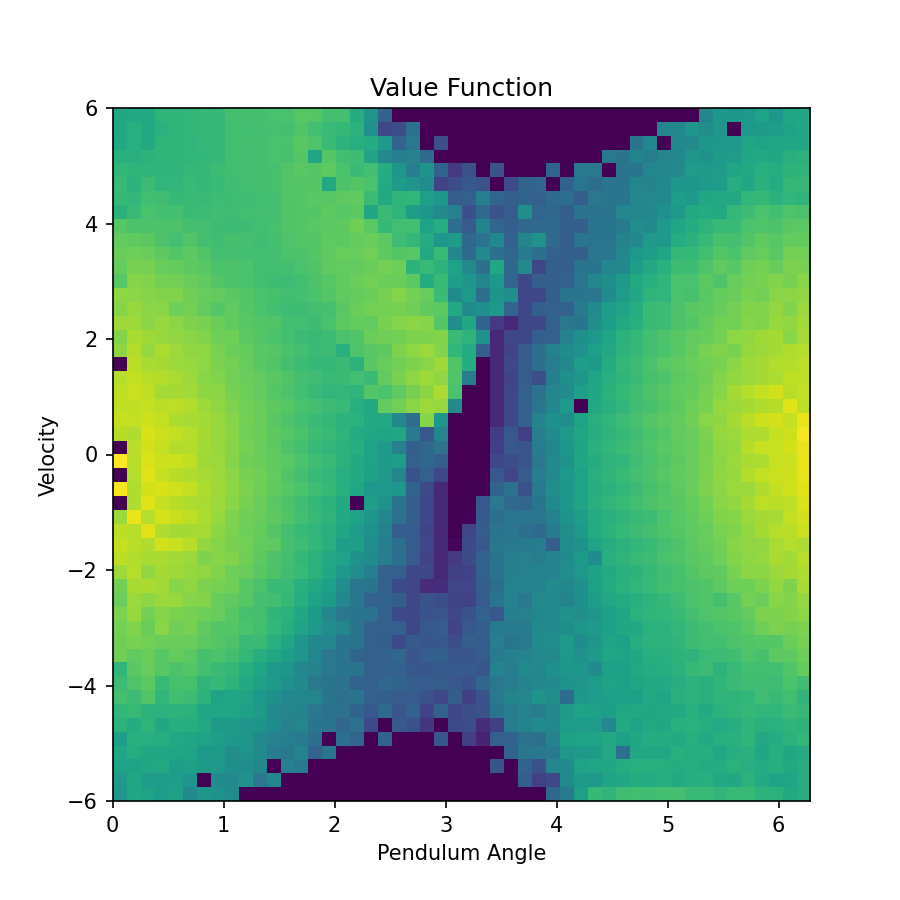

<IPython.core.display.Javascript object>


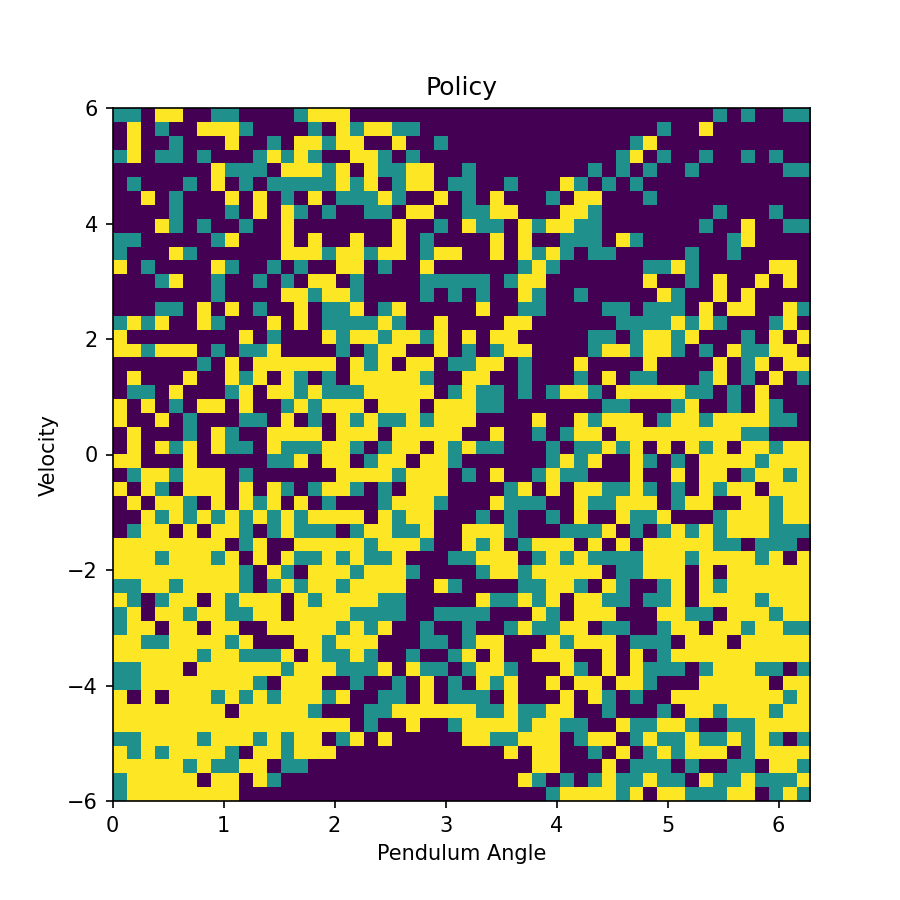

In [83]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2
# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

# now we simulate the dynamics for 100 time steps
x0 = np.array([0.,0.])

def controller(x):
    theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
    dtheta = np.linspace(-6, 6, 50)
    
    th_index = np.argmin(np.abs(theta - x[0]))
    dth_index = np.argmin(np.abs(dtheta - x[1]))
    return policy[th_index, dth_index]




<IPython.core.display.Javascript object>


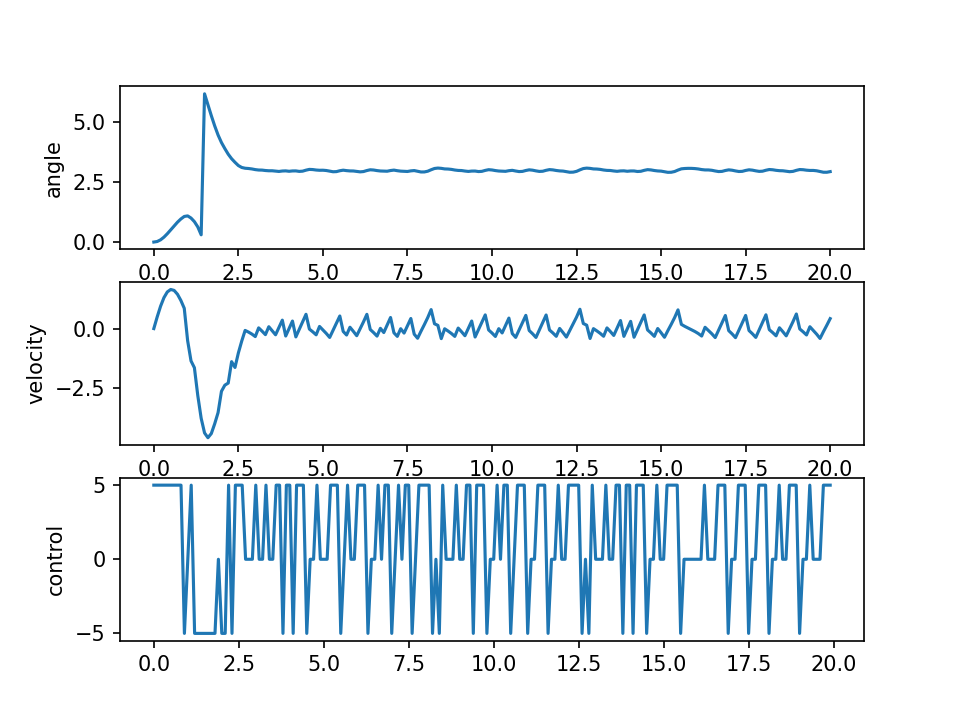

Text(0, 0.5, 'control')

In [81]:
x, u = robot.simulate(x0, controller, 20)

# and plot the results
time = np.linspace(0.,20., len(x[0,:]))
plt.figure()
plt.subplot(3,1,1)
plt.plot(time,x[0,:])
plt.ylabel('angle')
plt.subplot(3,1,2)
plt.plot(time,x[1,:])
plt.ylabel('velocity')
plt.subplot(3,1,3)
plt.plot(time[:-1],u)
plt.ylabel('control')


In [82]:
# and show an animation
robot.animate_robot(x, robot.delta_t)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAu1ttZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DPBliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI90bCsIyVc4u3PdLfonjvTAsNJVxmETQokGg2YmVSOf
r9cf7n4gzRN5w/yGp0C8urfaPNw7GLtuDKgU7CvsIolbNMN0bp4uNQArcYt3tWUUqb0q6OjBYObX
juYjxUGZABKLLHFN/6veiTXwCvzZQezV/g5HRLV1YnFqdeWGDbkCWfZmb1bEe4o0ZC8xjpEr120J
my/+CpVN/LCBb43mUw7YT7/K5nbUFjE2fWbHzRkNPuFoiIUAihHtmqc5GMh8KZmydt11qyMhkGLn
FFXrtho2ClWJWeetPg1hhapwI4HkY4/lqd7PdT98WYnH/7fy4MVhY8XXUGTwUhNXsk8tjiPqeltX
ADyJRFFavntZkvu+zacrh1N9kI2lQSKCRKSzbvoyYNHGr2T04T6g8hBfnDgZRWvsJO6LQri44cks
jn9ndxIqBL65W8nrREn89PP/Clm/3Sxn5kIlDj//viLf1v/DW0jtSCUG6mkqL2AAzI5C+aTKmr9E
iLap5hMZ6nxE7cC/DwixqHceOgK6FTBy9VwvNyNgTePOHhNdpdbCSHyhtgvd+57WFbDZrGicgf2o
TBXE7sZs3Xn28JozD5dZO3drk1fBbL4pWkKoan6Nrlf5qy/Jwm10y7sarghz9bhE7XuFPIAYftQ2
KMBWTgsxtGQQcxj/0zIBxbov2ui1Iv2L/dddvAuuENdK/zc96hF0+pmVN5guMot3ZCEPjj9cjI2Y
b7y9xtks8wMCj3IEPHbaFnFFHcH/YwNSaHr8WdDm1tCC2I09vdgHKOOEvDff2womAp1hfNU3M9G7
g/Sdspr2a6ZrjiaGxKZNWz6+FgOJvSlLNz4lNGkBEkZv9NRMagqctU/cP/AiYjsxq0RJheMJ4vcv
2UtGismjtT4PoP1rRRrcLWCEX8jiZ6qpaE1g7pXYc3pOGAynFU7d7jP9pV1BfF4tuJxd+NICfUaz
Sxx16xTIun0boR4omaYMymhO2t0Xc0pXPOc7GOLDsXfJUuA87CfS2fjE4q9xHZ4c9QXdEWi+jLH/
5ex9kv785XXxTJj1kOlCNuAZGGg2Xv7kVzLWsrRRKsXBuhimAMtruQhqVoUwGbE2KzOecgurxv8Z
UnMwelJWDKmVkK8Wp9CoBc1l5IjZp1FI/+RLcv5uBM5phr26SaRIGtg0IdgjP1pdgPPdUiasxJSS
52C78fPvha7Unc9izZOgexZTfcutOBO3UVApUW9ZvuxRxq+4ETgduU8hj7DSUwAMNbexW+lY374B
JHPk9G56zofoRHSmD3JILV2SPObSsu5bpbG66SFQyk1DXsThSyvwuYlz1LQWfLZh187XYr+2i3N+
2HlXm32DGzN1m+65XLfDTNso6ZHoi22lCmSd6ethD+/qRGoUrHa5wBYmvuTIqxlA6ViPZhGI8pfg
xhBhEEzW3x6tnpBLT8c551o8Nxnqd+XbdfyUAiobnUkVhXQ5grBmz+7as5Fj1aCLvQS05d6jdxjB
IStCHvGJ/+xwpVQC/K4r0+u9+r6zfCmgAeTsaUx11ZaOkzrwzuVIJwUkeotGmOUFZrtR4NL9hf3a
lvRXCphTKBngh4Zrpe8d3V35BpOVOq0k8plrn+UEonOBo3oelZAV8mi70JbJFfLLVovErtH4Tz9U
kdftXWk9odyWCVq9rFk/DdDBT63Gev7HAAAMuvAg26oIAiUt3yAAfYAAAAMBpH87cO4ZeRBMAa0E
Jv3yskaIsnj/rIvYl+Ub96+t43z2tz6hIbGY2lhZ7yY9Txmo/6op0bY39KiWUiuR4gEqTWLlHioe
oi9/vDrWLSyhEXekFxqnMP6wn6zZtPrOkwhk2jIqmbmSzp6qpYFs8AK3/NBrW4xyd8CycgE0Wk87
BBXhHVr1hV+KqdNrucu3gTjiUFxsP6ZzGVUarY+YUoZeRRiWgpitAPbsBPE7wpYdYQoQG0hVQKTU
YFZZ20HT4VyC0XiTv8BV9qKkHNVMXUZkEYwyA9CsHqjhCmImkb5Ipv+wZezm4kdHCv/qna6BPUz7
E4UOe15t15eu9BX/38aQjHNlTj39EQ0uWt2kyD0/VPh6TSXj6BkULZtPcH9pRjBt4E1OQzGs5cr/
vmrpezXR+6/l5V3DDDGRgxEKGleoYCGB0DMJwIjlkNk+wG3PWI4reHfCXNKDmPF15bhtTCIBRdpg
da8C1zzPeX5jHW5nfHHNF